# Neurochrirurgie sur les Transformers

## Introduction

Aujourd'hui, nous allons explorer les SAE (Auto-Encodeurs Parcimonieux). Cette technique a récemment fait parler d'elle grâce à un article d'Anthropic qui a révélé que Claude, leur modèle d'IA, avait identifié le concept de "Golden Bridge" grâce à cette méthode, et s'était même mis à prétendre qu'il était lui-même le fameux pont de San Francisco...

Notre objectif est de comprendre comment les SAE peuvent nous aider à décoder le fonctionnement interne des réseaux de neurones, en particulier des Transformers, qui sont à la base des LLMs comme ChatGPT, mais également de modèles de vision.

## Notre approche

1. **Entraînement d'un Transformer** : Nous allons d'abord entraîner un modèle Transformer sur le classique dataset MNIST (reconnaissance de chiffres manuscrits).

2. **Extraction des activations** : Une fois le modèle entraîné, nous allons extraire les activations du MLP (Multi-Layer Perceptron) lorsqu'on lui présente une image issue du MNIST.

3. **Entraînement d'un SAE** : Nous utiliserons ces activations comme données d'entrée pour entraîner un Auto-Encodeur Parcimonieux. Le SAE va apprendre de lui-même quels sont les concepts importants encodés dans cette couche du MLP.

4. **Intervention (neuro-chirurgie)** : Nous utiliserons cette séparation faite par le SAE pour intervenir sur les neurones par le biais du décodeur du SAE.

Cette approche nous permettra de "ouvrir la boîte noire" du Transformer et de comprendre quels types de caractéristiques ou de concepts il a appris à reconnaître dans les images de chiffres.

## Pourquoi est-ce important ?

L'interprétabilité des modèles d'apprentissage profond est un enjeu majeur en IA. Les SAE offrent une méthode prometteuse pour décomposer les représentations complexes apprises par ces modèles en concepts plus simples et interprétables. Cela pourrait nous aider à mieux comprendre comment ces modèles prennent leurs décisions, et potentiellement à les améliorer ou à détecter des biais.

Dans les sections suivantes, nous allons détailler chaque étape de ce processus, en commençant par la préparation des données MNIST et l'architecture de notre Transformer.

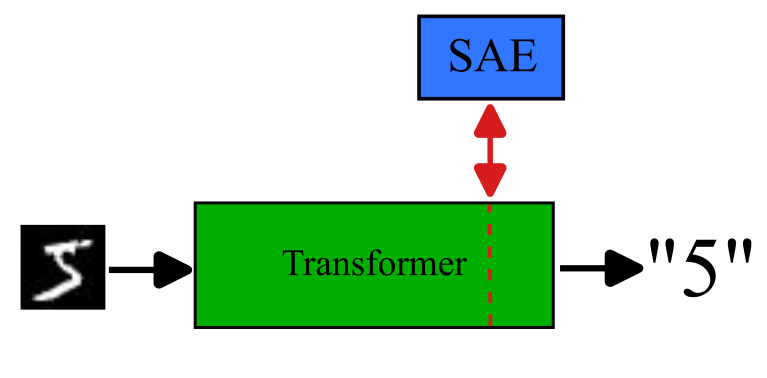

# Entraînement, probing, intervention avec SAE

## Mettre les choses en place

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
from datasets import load_dataset
import numpy as np

## Le MNIST

MNIST (Modified National Institute of Standards and Technology) est un jeu de données emblématique en apprentissage automatique, introduit en 1998 par Yann LeCun, Corinna Cortes et Christopher Burges. Il consiste en 70 000 images en niveaux de gris de chiffres manuscrits (0 à 9), chacune de taille 28x28 pixels. Le jeu est divisé en 60 000 images d'entraînement et 10 000 images de test.

MNIST a joué un rôle crucial dans le développement de techniques de reconnaissance de formes et reste un ``"Hello World"`` de l'apprentissage profond. 

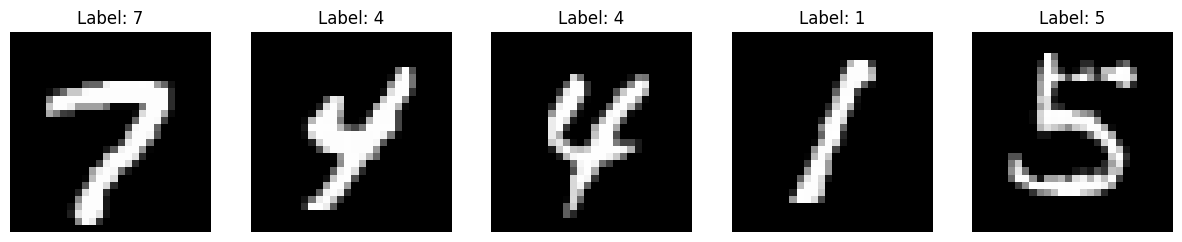

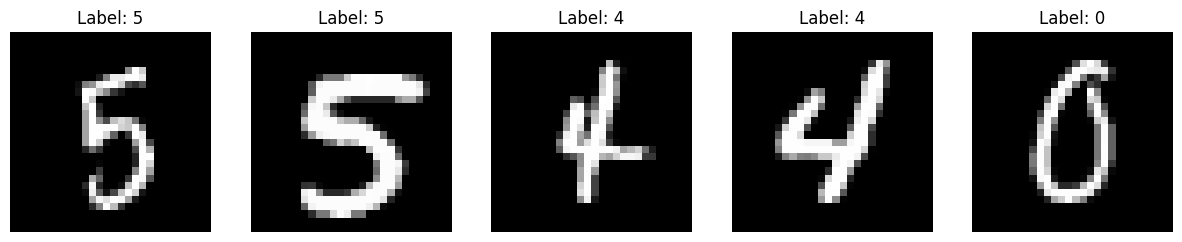

In [23]:
# Chargement et préparation du dataset
dataset = load_dataset("mnist")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

def preprocess(examples):
    examples["pixel_values"] = [torch.tensor(np.array(img), dtype=torch.float32).view(1, 28, 28) / 255.0
                                for img in examples["image"]]
    return examples

train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["image"])
test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["image"])
train_dataset.set_format(type="torch", columns=["pixel_values", "label"])
test_dataset.set_format(type="torch", columns=["pixel_values", "label"])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fonction pour afficher des échantillons
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img = dataset[idx]["pixel_values"].squeeze().numpy()
        label = dataset[idx]["label"]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Afficher des échantillons du jeu d'entraînement
show_samples(train_dataset)

# Afficher des échantillons du jeu de test
show_samples(test_dataset)

## Le Transformer

Qu'est-ce qu'un Transformer ? C'est une architecture assez complexe de modèle, qui comprend trois étapes principales :

Le plongement (ou *embedding*) des mots dans des espaces en grande dimension. Concrètement, chaque mot se voit associer un vecteur qui vit dans un espace de grande dimension $\mathbb{R}^n$. Ces vecteurs sont appris durant l'entraînement. Cela permet en quelque sorte d'encoder la *sémantique* de chaque mot. Soit $$w$$ un mot, son plongement $$e_w$$ est défini par :

$$e_w = E w$$

où $E$ est la matrice de plongement apprise.

Le mécanisme d'attention, qui permet de calculer les dépendances entre les différents mots d'une phrase. Ce sont trois matrices $Q$, $K$ et $V$ qui sont apprises durant l'entraînement, et qui permettent de projeter l'importance relative des mots précédents sur le suivant. L'attention est calculée comme suit :

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

où $d_k$ est la dimension des clés.

Le perceptron multi-couche, qui permet de manipuler les concepts abstraits. C'est un réseau de neurones on ne peut plus classique, entièrement connecté, traditionnellement à deux couches et faisant quatre fois la taille du plongement. Sa fonction peut être représentée comme :

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

où $W_1$, $W_2$, $b_1$, et $b_2$ sont les paramètres appris.

In [24]:
# Paramètres
batch_size = 1024
num_epochs = 5
learning_rate = 0.001
d_model = 64
nhead = 2
num_layers = 2

In [25]:
# Modèle Transformer
class MNISTTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, num_classes=10):
        super(MNISTTransformer, self).__init__()
        self.embedding = nn.Linear(28*28, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, d_model))
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, return_activations=False):
        x = x.view(x.size(0), -1)  # Aplatir l'image (batch_size, 784)
        x = self.embedding(x)  # (batch_size, d_model)
        x = x + self.pos_encoder  # Diffusion du pos_encoder
        x = x.unsqueeze(1)  # Ajouter une dimension de séquence (batch_size, 1, d_model)

        activations = None
        for i, layer in enumerate(self.transformer_layers):
            x = layer(x)
            if i == 1 and return_activations:
                activations = x.clone()

        x = x.squeeze(1)  # Retirer la dimension de séquence (batch_size, d_model)
        x = self.fc(x)

        if return_activations:
            return x, activations
        return x

## Le SAE

Qu'est-ce qu'un SAE ? En français *Auto-Encodeur Parcimonieux*, le SAE est un modèle qui prend en entrée une donnée $x$, et doit rendre la même donnée en sortie $\hat{x}$ (d'où le "Auto"). L'idée derrière ce modèle est qu'il encode l'information contenue dans la donnée, en tout cas sa *substantifique moelle*, dans une représentation cachée $h$.

Mathématiquement, cela peut s'exprimer comme :

$$h = f(x) = \sigma(Wx + b)$$
$$\hat{x} = g(h) = \sigma(W'h + b')$$

où $f$ est la fonction d'encodage et $g$ la fonction de décodage.

La parcimonie garantit que la solution trouvée sera très simple, appliquant ainsi le *rasoir d'Occam*, qui nous dit de privilégier les solutions simples lorsque plusieurs solutions s'offrent à nous. Cette parcimonie est obtenue en ajoutant un terme de régularisation $\Omega(h)$ à la fonction objectif :

$$\min_{W, W', b, b'} L(x, \hat{x}) + \lambda \Omega(h)$$

où $L$ est une fonction de perte mesurant la différence entre l'entrée et la sortie reconstruite, et $\lambda$ contrôle le degré de parcimonie.

Nous avons donc une couche linéaire pour encoder l'information, et une couche linéaire pour la décoder. 

In [26]:
sae_hidden_dim = 256 #Une dimension qui doit impérativement être un carré, pour la visualisation

In [27]:
# Modèle SAE
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

## L'entraînement

Cette fonction a pour but d'évaluer à quel point le Transformer prédit bien les étiquettes associées aux images du MNIST. C'est un fonction de précision, et ce qu'elle rend est un pourcentage d'exemples correctement classifiés. 

In [28]:
# Fonction d'évaluation pour le Transformer
def evaluate_transformer(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs, _ = model(inputs, return_activations=True)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

Le critère de la fonction de perte pour le Transformer est l'entropie croisée (``nn.CrossEntropyLoss()``), qui permet de calculer la distance entre deux distributions. Dans ce contexte, nous comparons :

1. La distribution attendue, qui est une distribution certaine puisqu'une seule étiquette est prévue pour chaque image. Elle est représentée par un vecteur unitaire $y$ (*one-hot encoding*) :

   $$y = (0, 0, ..., 1, ..., 0)$$

2. La distribution à la sortie du Transformer, que nous appellerons $\hat{y}$ :

   $$\hat{y} = (\hat{y}_1, \hat{y}_2, ..., \hat{y}_n)$$

   où $n$ est le nombre de classes possibles.

L'entropie croisée entre ces deux distributions est définie comme suit :

$$H(y, \hat{y}) = -\sum_{i=1}^n y_i \log(\hat{y}_i)$$

Dans le cas d'une distribution certaine (*one-hot encoding*), ce qui est le cas ici, cette formule se simplifie à :

$$H(y, \hat{y}) = -\log(\hat{y}_c)$$

où $c$ est l'indice de la classe correcte.

L'objectif de l'entraînement est de minimiser cette entropie croisée, ce qui revient à maximiser la probabilité que le modèle assigne à la classe correcte.

In [29]:
# Initialisation des modèles
transformer = MNISTTransformer(d_model, nhead, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)

# Entraînement du Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)

MNISTTransformer(
  (embedding): Linear(in_features=784, out_features=64, bias=True)
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [30]:
for epoch in range(num_epochs):
    transformer.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs, _ = transformer(inputs, return_activations=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = evaluate_transformer(transformer, test_loader, criterion, device)

    print(f"Transformer Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("Entraînement du Transformer terminé!")

Transformer Epoch [1/5]
  Train Loss: 0.3206
  Test Loss: 0.2052, Test Accuracy: 93.72%
Transformer Epoch [2/5]
  Train Loss: 0.1521
  Test Loss: 0.1090, Test Accuracy: 96.58%
Transformer Epoch [3/5]
  Train Loss: 0.1140
  Test Loss: 0.0912, Test Accuracy: 97.29%
Transformer Epoch [4/5]
  Train Loss: 0.0920
  Test Loss: 0.0932, Test Accuracy: 97.16%
Transformer Epoch [5/5]
  Train Loss: 0.0751
  Test Loss: 0.1098, Test Accuracy: 96.89%
Entraînement du Transformer terminé!


Une fois le transformer entraîné, on collecte les activations de la couche de MLP, c'est à dire les états des vecteurs lorsqu'on donne une image du MNIST à notre Transformer. C'est comme si on prenait un instantané de la pensée de notre Transformer.

In [31]:
# Collecter les activations
transformer.eval()
activations = []
with torch.no_grad():
    for batch in train_loader:
        inputs = batch['pixel_values'].to(device)
        _, batch_activations = transformer(inputs, return_activations=True)
        activations.append(batch_activations.squeeze(1).cpu())

activations = torch.cat(activations, dim=0)

Avec ces activations, on peut entraîner notre SAE, qui va s'efforcer de rendre la même activation, en l'encodant avec le moins de neurones activés possible (la plupart vaut zéro comme on le verra). 

In [32]:
# Fonction d'entraînement du SAE
def train_sae(sae, activation_loader, num_epochs=100, learning_rate=0.001, sparsity_weight=1):
    optimizer = optim.Adam(sae.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in activation_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            decoded, encoded = sae(batch)
            reconstruction_loss = criterion(decoded, batch)
            sparsity_loss = torch.mean(torch.abs(encoded))
            loss = reconstruction_loss + sparsity_weight * sparsity_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"SAE Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(activation_loader):.4f}")


In [33]:
# Initialiser et entraîner le SAE
sae = SparseAutoencoder(d_model, sae_hidden_dim)
sae.to(device)
activation_dataset = TensorDataset(activations)
activation_loader = DataLoader(activation_dataset, batch_size=batch_size, shuffle=True)
train_sae(sae, activation_loader)

print("Entraînement du SAE terminé!")

SAE Epoch [1/100], Loss: 0.5539
SAE Epoch [2/100], Loss: 0.1954
SAE Epoch [3/100], Loss: 0.1382
SAE Epoch [4/100], Loss: 0.1055
SAE Epoch [5/100], Loss: 0.0860
SAE Epoch [6/100], Loss: 0.0726
SAE Epoch [7/100], Loss: 0.0629
SAE Epoch [8/100], Loss: 0.0559
SAE Epoch [9/100], Loss: 0.0506
SAE Epoch [10/100], Loss: 0.0465
SAE Epoch [11/100], Loss: 0.0430
SAE Epoch [12/100], Loss: 0.0401
SAE Epoch [13/100], Loss: 0.0376
SAE Epoch [14/100], Loss: 0.0354
SAE Epoch [15/100], Loss: 0.0335
SAE Epoch [16/100], Loss: 0.0318
SAE Epoch [17/100], Loss: 0.0304
SAE Epoch [18/100], Loss: 0.0291
SAE Epoch [19/100], Loss: 0.0279
SAE Epoch [20/100], Loss: 0.0269
SAE Epoch [21/100], Loss: 0.0260
SAE Epoch [22/100], Loss: 0.0251
SAE Epoch [23/100], Loss: 0.0244
SAE Epoch [24/100], Loss: 0.0236
SAE Epoch [25/100], Loss: 0.0230
SAE Epoch [26/100], Loss: 0.0223
SAE Epoch [27/100], Loss: 0.0217
SAE Epoch [28/100], Loss: 0.0212
SAE Epoch [29/100], Loss: 0.0206
SAE Epoch [30/100], Loss: 0.0201
SAE Epoch [31/100],

## Visualisation

Ce code permet de visualiser toutes les étapes intéressantes.

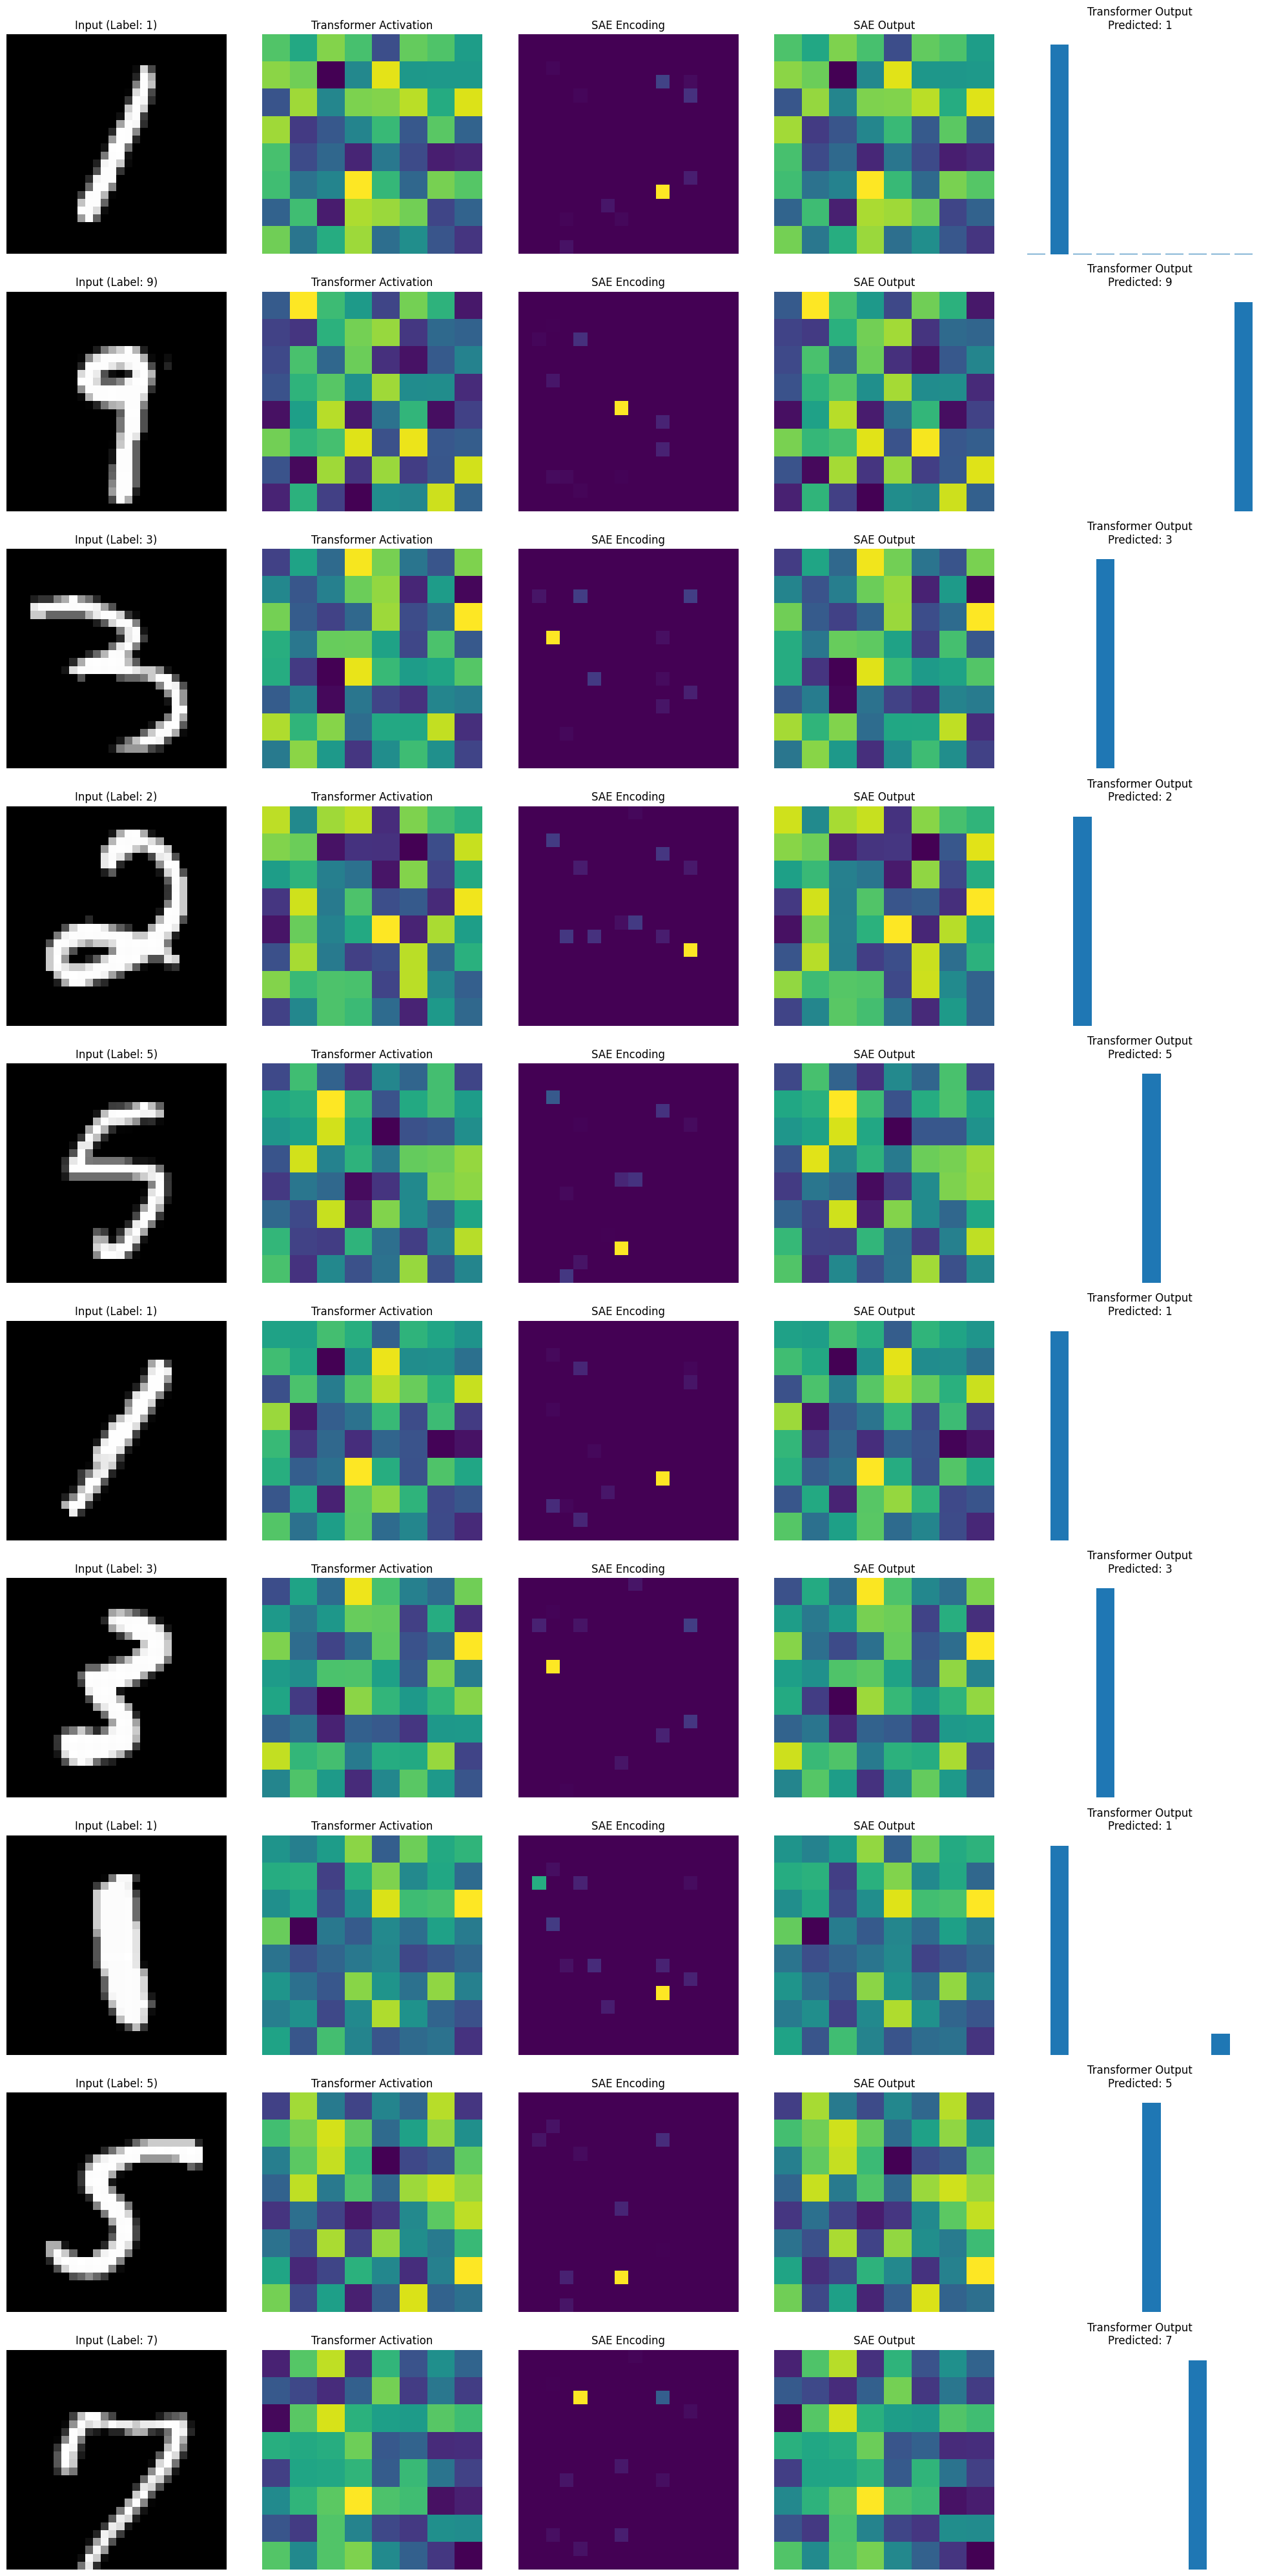

In [37]:
def visualize_process(transformer, sae, test_loader, num_samples=10):
    device = next(transformer.parameters()).device
    transformer.eval()
    sae.eval()

    # Sélectionner des échantillons aléatoires
    all_samples = []
    for batch in test_loader:
        all_samples.extend(list(zip(batch['pixel_values'], batch['label'])))
    random_samples = random.sample(all_samples, num_samples)

    fig, axs = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

    for i, (image, label) in enumerate(random_samples):
        image = image.to(device)

        # Image originale
        axs[i, 0].imshow(image.cpu().squeeze().numpy(), cmap='gray')
        axs[i, 0].set_title(f"Input (Label: {label})")

        # Transformer activation
        with torch.no_grad():
            transformer_output = transformer(image.unsqueeze(0), return_activations=True)
            transformer_activation = transformer_output[-1].squeeze().cpu()

        # SAE encoding et decoding
        with torch.no_grad():
            sae_output, sae_encoding = sae(transformer_activation.to(device))

        # Affichage de l'activation du Transformer
        axs[i, 1].imshow(transformer_activation.numpy().reshape(int(np.sqrt(transformer_activation.shape[0])), -1), cmap='viridis')
        axs[i, 1].set_title("Transformer Activation")

        # Affichage de l'encodage SAE
        axs[i, 2].imshow(sae_encoding.cpu().numpy().reshape(int(np.sqrt(sae_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 2].set_title("SAE Encoding")

        # Affichage de la sortie SAE
        axs[i, 3].imshow(sae_output.cpu().numpy().reshape(int(np.sqrt(sae_output.shape[0])), -1), cmap='viridis')
        axs[i, 3].set_title("SAE Output")

        # Affichage de la sortie du Transformer
        with torch.no_grad():
            transformer_output = transformer(image.unsqueeze(0))
        predicted_class = torch.argmax(transformer_output).item()
        axs[i, 4].bar(range(10), nn.functional.softmax(transformer_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 4].set_title(f"Transformer Output\nPredicted: {predicted_class}")
        axs[i, 4].set_xticks(range(10))

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction
visualize_process(transformer, sae, test_loader)

Description :

* première colonne : input du transformer
* deuxième : état de la couche de sortie du MLP dans le transformer
* troisième : état de la couche de code du SAE, qui a été entraîné sur ladite couche de sortie du MLP
* quatrième : couche prédite par le SAE après décodage (identique à l'entrée donc)
* cinquième : output du transformer, c'est-à dire une distribution sur les labels des chiffres. Tellement bien entraîné qu'il est certain...

## Chirurgie du Transformer ! (à vous de jouer)

Voici le code qui permet d'intervenir directement sur les neurones, et qui permet de modifier le "flux de pensée" du Transformer : on peut lui faire croire qu'il voit un 0 alors qu'il a un autre chiffre en entrée ! 

In [35]:
def visualize_process_with_intervention(transformer, sae, test_loader, num_samples=2, neuron_position=None, intensity=1.0):
    device = next(transformer.parameters()).device
    transformer.eval()
    sae.eval()

    all_samples = []
    for batch in test_loader:
        all_samples.extend(list(zip(batch['pixel_values'], batch['label'])))
    random_samples = random.sample(all_samples, num_samples)

    fig, axs = plt.subplots(num_samples, 7, figsize=(28, 4*num_samples))
    fig.suptitle(f"Visualisation du processus Transformer-SAE avec intervention (Neurone: {neuron_position}, Intensité: {intensity})", fontsize=16)

    for i, (image, label) in enumerate(random_samples):
        image = image.to(device)

        # Image originale
        axs[i, 0].imshow(image.cpu().squeeze().numpy(), cmap='gray')
        axs[i, 0].set_title(f"Input (Label: {label})")

        # Transformer activation
        with torch.no_grad():
            original_output, transformer_activation = transformer(image.unsqueeze(0), return_activations=True)
            transformer_activation = transformer_activation.squeeze().cpu()

        # SAE encoding et decoding
        with torch.no_grad():
            sae_output, sae_encoding = sae(transformer_activation.to(device))

        # Affichage de l'activation du Transformer
        axs[i, 1].imshow(transformer_activation.numpy().reshape(int(np.sqrt(transformer_activation.shape[0])), -1), cmap='viridis')
        axs[i, 1].set_title("Transformer Activation")

        # Affichage de l'encodage SAE original
        axs[i, 2].imshow(sae_encoding.cpu().numpy().reshape(int(np.sqrt(sae_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 2].set_title("SAE Encoding (Original)")

        # Intervention manuelle sur l'encodage SAE
        modified_encoding = sae_encoding.clone()
        if neuron_position is not None:
            modified_encoding[neuron_position] += intensity
        else:
            # Si aucun neurone spécifique n'est choisi, on modifie le premier quart comme avant
            region_size = sae_encoding.shape[0] // 4
            modified_encoding[:region_size] *= intensity

        # Affichage de l'encodage SAE modifié
        axs[i, 3].imshow(modified_encoding.cpu().numpy().reshape(int(np.sqrt(modified_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 3].set_title("SAE Encoding (Modified)")

        # Décodage de l'encodage modifié
        with torch.no_grad():
            modified_output = sae.decoder(modified_encoding.to(device))

        # Affichage de la sortie SAE modifiée
        axs[i, 4].imshow(modified_output.cpu().numpy().reshape(int(np.sqrt(modified_output.shape[0])), -1), cmap='viridis')
        axs[i, 4].set_title("Modified SAE Output")

        # Affichage de la sortie du Transformer original
        original_predicted_class = torch.argmax(original_output).item()
        axs[i, 5].bar(range(10), nn.functional.softmax(original_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 5].set_title(f"Original Output\nPredicted: {original_predicted_class}")
        axs[i, 5].set_xticks(range(10))

        # Calcul de la sortie du Transformer avec intervention
        with torch.no_grad():
            # Préparation des données pour le passage à travers le transformer
            x = image.view(1, -1)  # Aplatir l'image (1, 784)
            x = transformer.embedding(x)  # (1, d_model)
            x = x + transformer.pos_encoder  # Diffusion du pos_encoder
            x = x.unsqueeze(1)  # Ajouter une dimension de séquence (1, 1, d_model)

            # Passage à travers les couches du transformer
            for j, layer in enumerate(transformer.transformer_layers):
                if j == 1:
                    # Remplacer l'activation de la deuxième couche par l'activation modifiée
                    x = modified_output.unsqueeze(0).unsqueeze(0)
                else:
                    x = layer(x)

            x = x.squeeze(1)  # Retirer la dimension de séquence (1, d_model)
            modified_transformer_output = transformer.fc(x)

        modified_predicted_class = torch.argmax(modified_transformer_output).item()
        axs[i, 6].bar(range(10), nn.functional.softmax(modified_transformer_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 6].set_title(f"Modified Output\nPredicted: {modified_predicted_class}")
        axs[i, 6].set_xticks(range(10))

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction
# Pour modifier un neurone spécifique, utilisez :
# visualize_process_with_intervention(transformer, sae, test_loader, neuron_position=42, intensity=2.0)
# Pour modifier une région, utilisez :
# visualize_process_with_intervention(transformer, sae, test_loader, intensity=2.0)
# visualize_process_with_intervention(transformer, sae, test_loader)

### Comment persuader un transformer qu'il voit un zéro, alors qu'il a un autre chiffre devant ses yeux ?

Le neurone lié au 0 dans le SAE (lorsque je l'ai entraîné) est le **neurone 158**. L'intensité est fixée à 2, ce qui permet de compenser les autres neurones déjà activer, pour forcer les choses.

Usage : Pour modifier un neurone, mettez `neuron_position` = `index` du neurone que vous voulez triturer, et changez son intensité !

*Note : à chaque entraînement du modèle, la place du neurone change, il faut donc observer attentivement la position du neurone en question dans la sortie au dessus.*

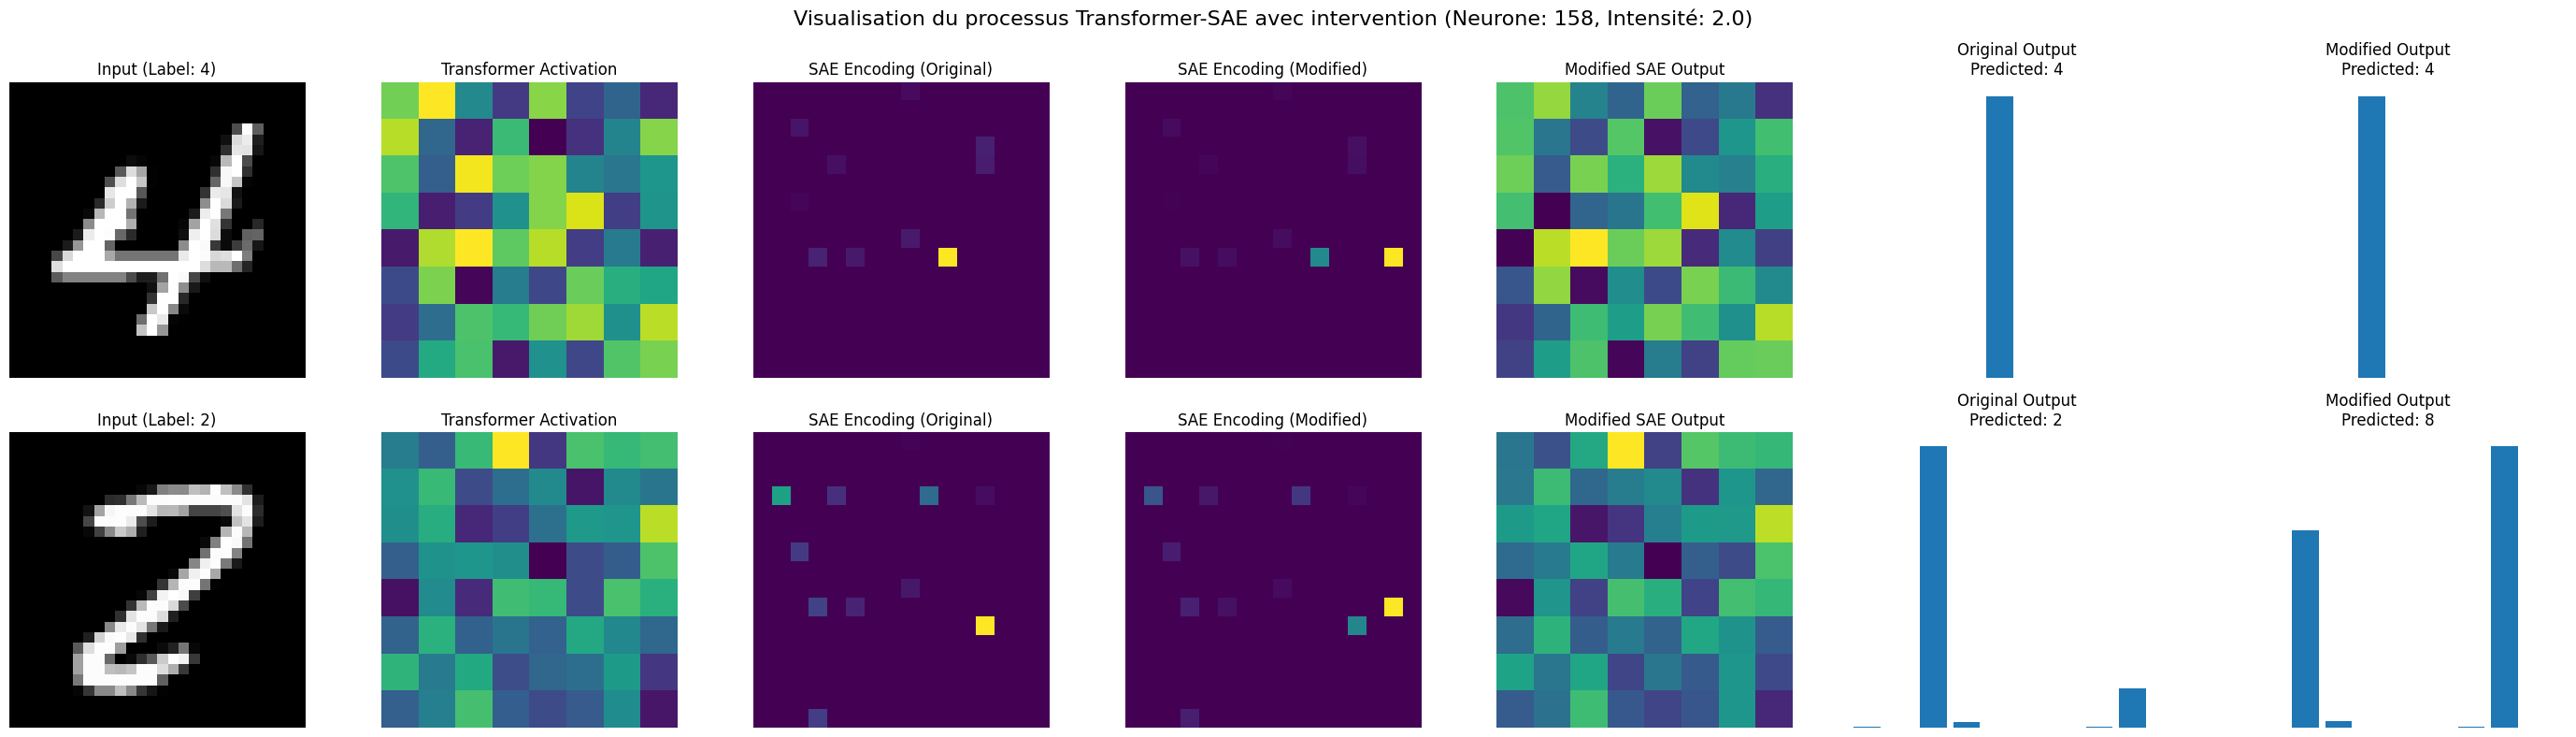

In [36]:
visualize_process_with_intervention(transformer, sae, test_loader, neuron_position=158, intensity=2.0)

*Et voilà comment on finit par croire qu'on est le Golden Bridge...*

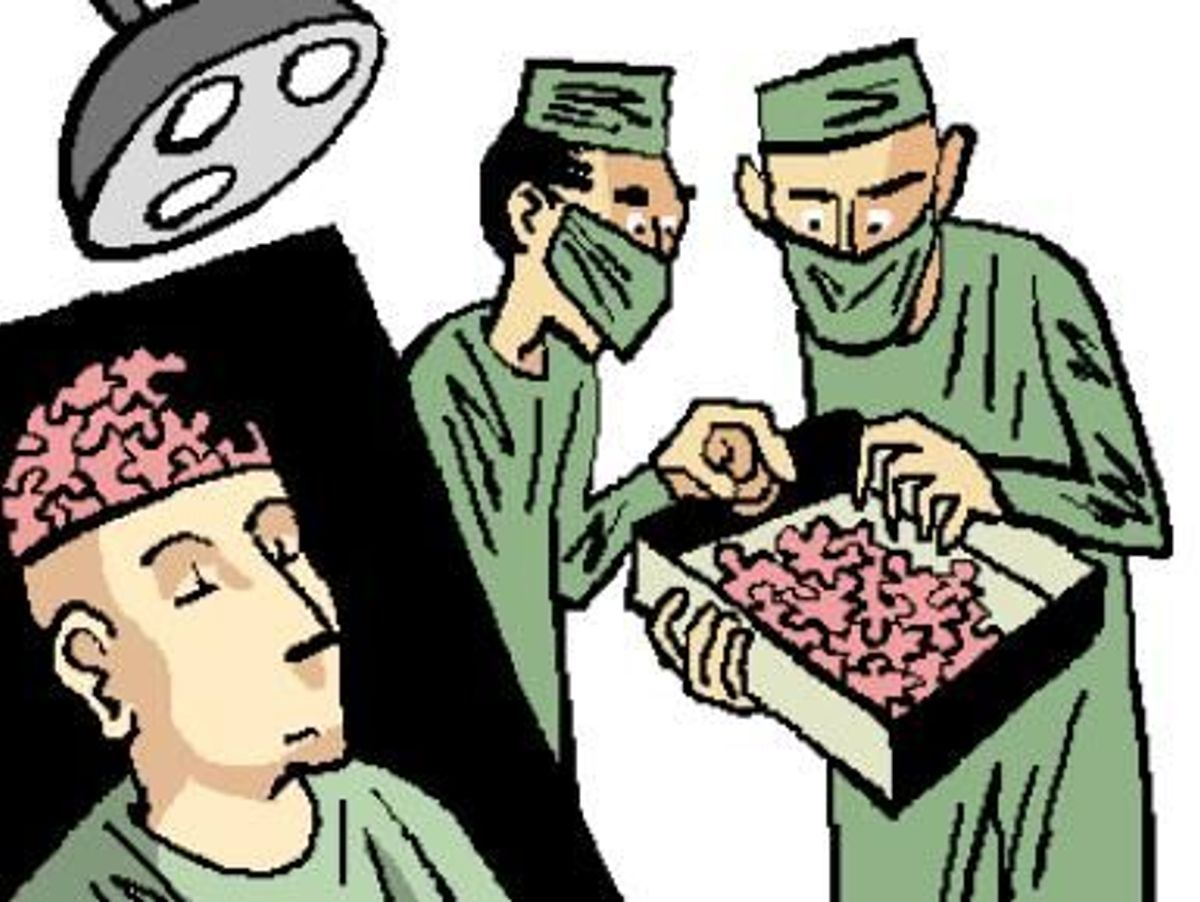